In [1]:
import pandas as pd
%pip install --upgrade kneed
from kneed import KneeLocator 
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

import numpy as np
from collections import Counter

%pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
#Load your dataset
file_path = "../csvs/shuffled_data.csv"
data = pd.read_csv(file_path)

#Drop the last column
X = data.drop(columns=["target"])

#print the shape of the dataset
print("Shape", X.shape)

#dataset has 1303 datapoints and 12 features


Shape (1303, 12)


In [3]:
#normalize the data so that all features contribute equally to clustering
scalar = StandardScaler()
X_scaled = scalar.fit_transform(X)

#print the shape of the scaled dataset
print("Shape", X_scaled.shape)

#dataset still has 1303 datapoints and 12 features

Shape (1303, 12)


In [4]:
#To find MinPts, we apply 2 * num_features for a multi-dimensional dataset, 11
MinPts = 11

#check for proper MinPts value
print("MinPts", MinPts)

MinPts 11


Text(0, 0.5, 'KNN Distances')

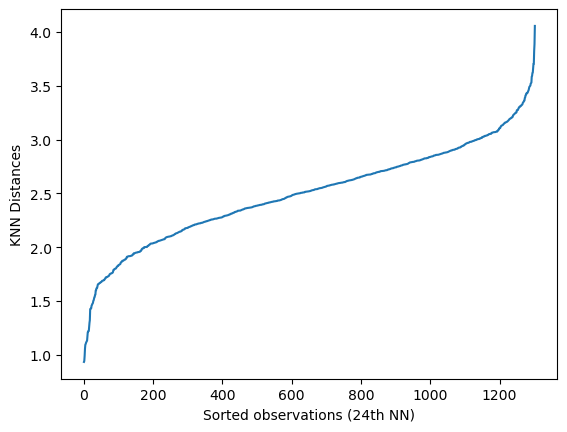

In [5]:
#determine optimal epsilon value through KNN
neighbors = NearestNeighbors(n_neighbors=MinPts + 1) #we want to include the distance of points to itself
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)


#sort distance values to determine best epsilon value
sorted_dist = np.sort(distances, axis=0) #sorting along the first axis
k_dist = sorted_dist[:, MinPts] #based on MinPts
plt.plot(k_dist)

#make sure to label the x and y-axis
plt.xlabel("Sorted observations (24th NN)")
plt.ylabel("KNN Distances")

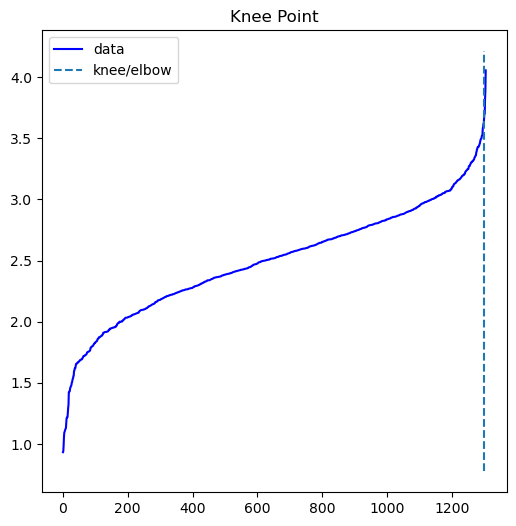

In [6]:
#we want to estimate the proper elbow point for epsilon
kneedle = KneeLocator(x=range(1, len(distances) + 1), y = k_dist, S=1.0, 
                      curve="concave", direction="increasing", online=True)

#plot the graph
kneedle.plot_knee()
plt.show()

In [7]:
#get the estimate for the kneedle point
print("Epsilon value", kneedle.knee_y)

Epsilon value 3.7030964667779642


In [8]:
#set the optimal value for epsilon (took the value divided by 2)
e = 1.85

#perform DBSCAN
clusters = DBSCAN(eps=e, min_samples=MinPts).fit(X_scaled)

#retrieve the labels of the clusters
clusters.labels_

#check unique clusters
set(clusters.labels_)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

In [9]:
#try measuring the cluster size
Counter(clusters.labels_)


Counter({-1: 1018,
         2: 49,
         1: 46,
         0: 32,
         3: 28,
         8: 24,
         6: 24,
         5: 21,
         7: 20,
         4: 19,
         9: 11,
         10: 11})

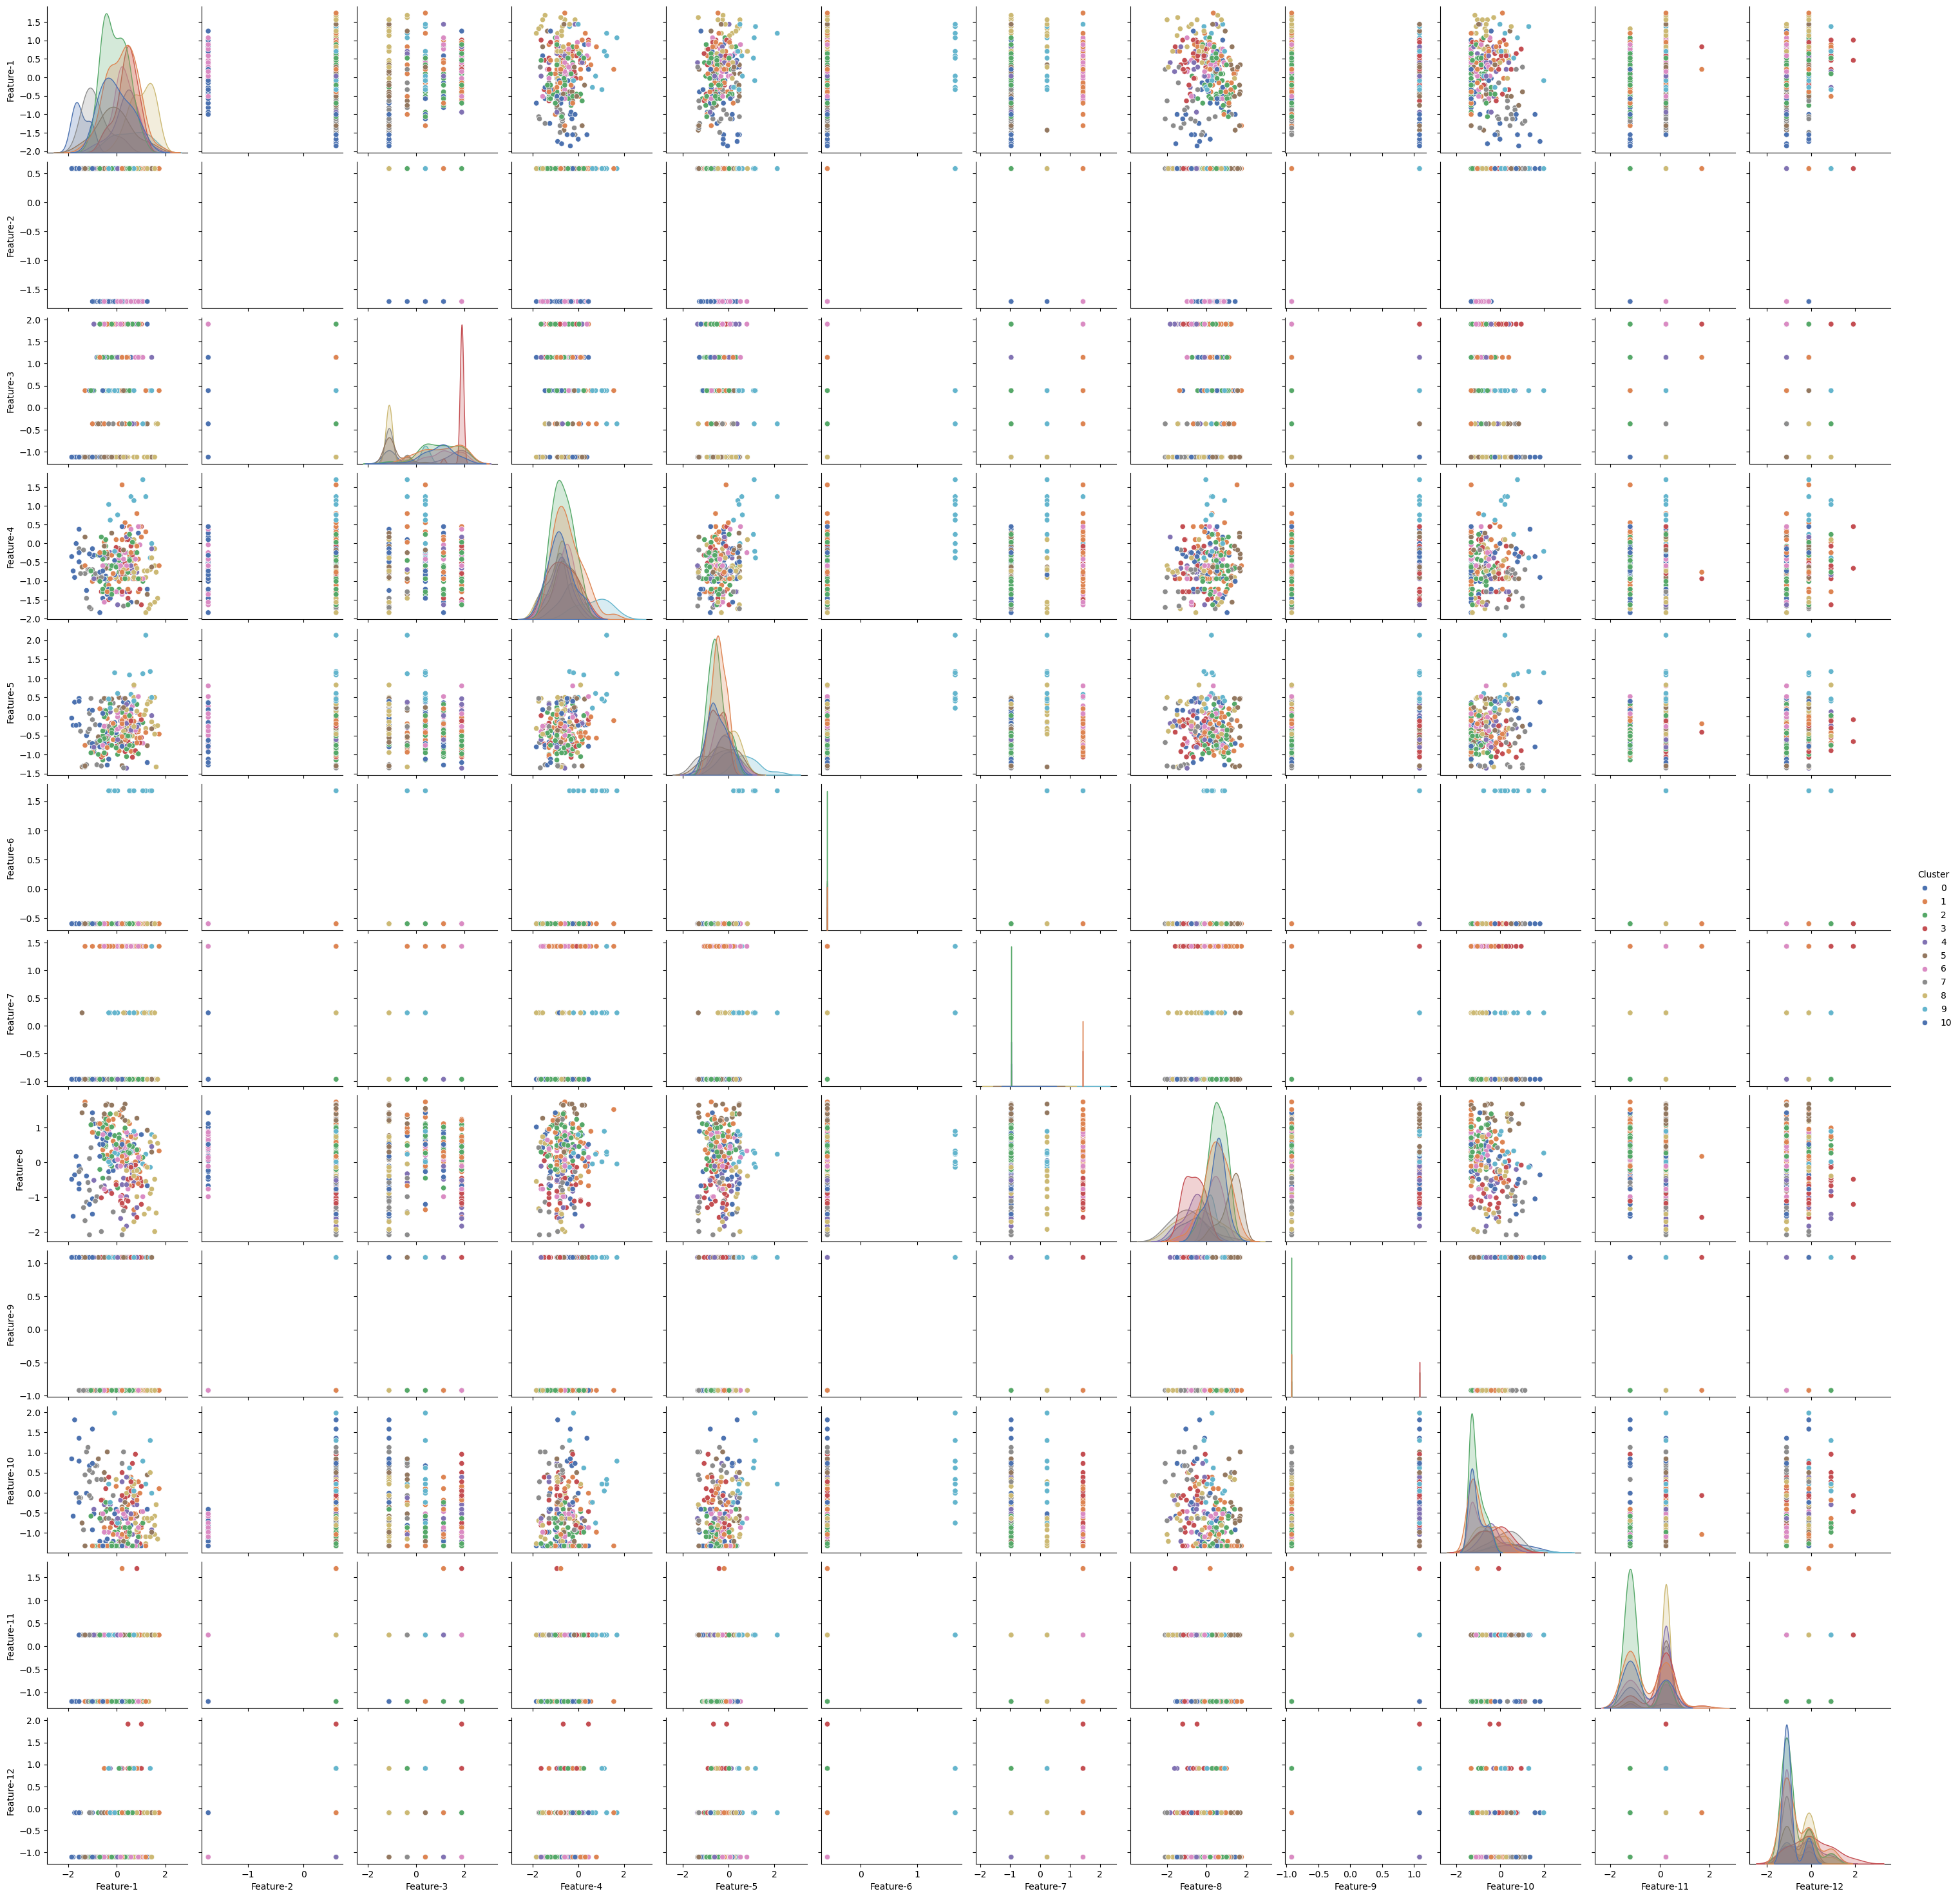

In [10]:
# Assuming X_scaled is a NumPy array with two components from PCA
column_names = [f"Feature-{i+1}" for i in range(X_scaled.shape[1])]
X_scaled_df = pd.DataFrame(X_scaled, columns=column_names)

# Add the cluster labels
X_scaled_df["Cluster"] = clusters.labels_

filtered_df = X_scaled_df[X_scaled_df["Cluster"] != -1]

#p = sns.scatterplot(data = X_scaled_df, x = "PCA-4", y = "PCA-5", hue = clusters.labels_, legend = "full", palette = "deep")
#sns.move_legend(p, "upper right", bbox_to_anchor = (1.17, 1.), title = 'Clusters')
sns.pairplot(filtered_df, hue="Cluster", palette="deep")
plt.show()

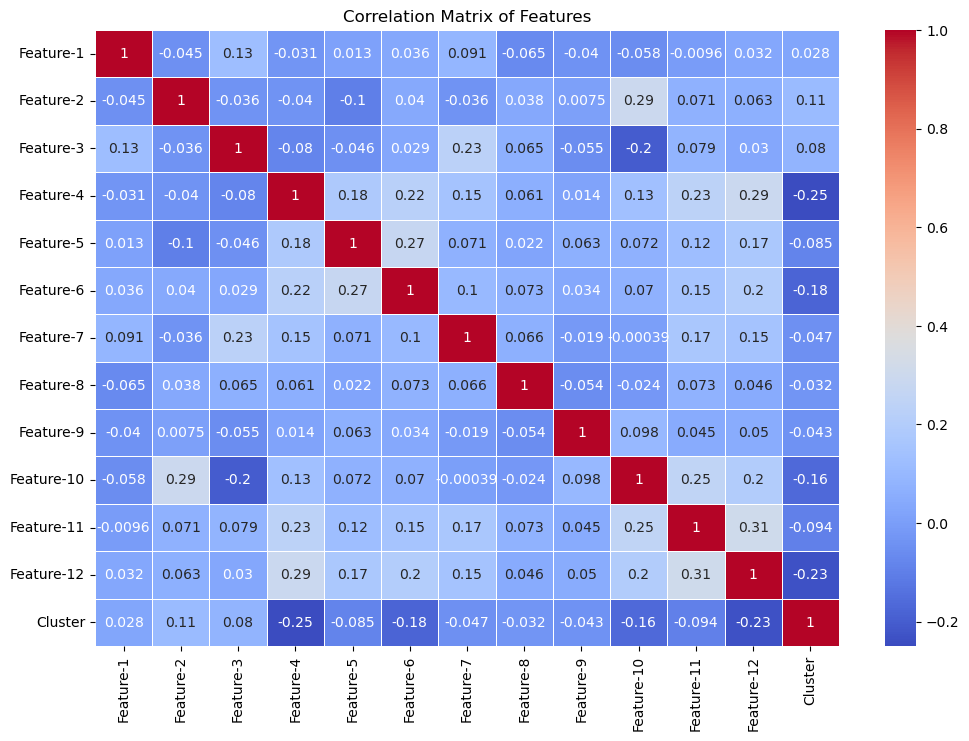

In [11]:
# Compute the correlation matrix
corr_matrix = X_scaled_df.corr()

# Plot a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Features")
plt.show()

In [21]:
#we are going to measure different metrics to assess the quality of DBSCAN clustering
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import completeness_score
from sklearn.metrics import fowlkes_mallows_score


labels = clusters.labels_
true_labels = data["target"].values

#Davies-Bouldin Index
db_score = davies_bouldin_score(X, labels)
print("Davies-Bouldin Index: ",  db_score)

#adjusted_rand_score
ari_score = adjusted_rand_score(true_labels, labels)
print("Adjusted Random score", ari_score)

silhouette_avg = silhouette_score(X, labels)
print("Silhouette Score", silhouette_avg)

score = completeness_score(true_labels, labels)
print("Completeness Score", score)

fw_score = fowlkes_mallows_score(true_labels, labels)
print("Fowlkes-Mallows Score", fw_score)

Davies-Bouldin Index:  6.9588651170362725
Adjusted Random score 0.05275791100191815
Silhouette Score -0.3941917482547643
Completeness Score 0.07617651028723543
Fowlkes-Mallows Score 0.5810495379749797
